# Graph Attention Network
This notebook demonstrates the training of [Graph Attention Networks](https://arxiv.org/abs/1710.10903) with TigerGraph. [Pytorch Geometric](https://pytorch-geometric.readthedocs.io)'s implementation of GAT is used here. We train the model on the Cora dataset from [PyG datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) with TigerGraph as the data store. The dataset contains 2708 machine learning papers and 10556 citation links between the papers.  Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from a dictionary. The dictionary consists of 1433 unique words. Each paper is classified into one of seven classes based on the topic. The goal is to predict the class of each vertex in the graph.

The following libraries are required to run this notebook. Uncomment to install them if necessary. You might need to restart the kernel after installing.

In [ ]:
#!pip install torch==1.12.0 --extra-index-url https://download.pytorch.org/whl/cpu
#!pip install torch-scatter==2.0.9 torch-sparse==0.6.14 torch-cluster==1.6.0 torch-spline-conv==1.2.1 torch-geometric==2.0.4 -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
#!pip install pyTigerGraph[gds]
#!pip install tensorboard # If you use tensorboard for visualization later

**NOTE**: Currently, your database needs to be activated (only once) to enjoy all the functions provided by the ML Workbench. If you are using ML Workbench on Cloud, then the activator is included and you can run the cell below (uncomment first) to activate. For other versions of the Workbench, you can download the activator at https://act.tigergraphlabs.com. Detailed instructions are also included on that website. 

In [ ]:
# Uncomment below and fill out the necessary information. For detailed instructions, please see https://act.tigergraphlabs.com
# !mlwb activate [database address] -u [username] -p [password] -s [secret]

## Table of Contents
* [Data Processing](#data_processing)  
* [Train on whole graph](#train_whole)  
* [Train on neighborhood subgraphs](#train_subgraph)  
* [Inference](#inference)

## Data Processing <a name="data_processing"></a>

Here we assume the dataset is already ingested into the TigerGraph database. If not, please refer to the  [data ingestion](https://github.com/TigerGraph-DevLabs/mlworkbench-docs/blob/main/tutorials/basics/0_data_ingestion.ipynb) tutorial first. Since the dataset already has a split of vertices into train/validation/test sets, we don't need to do so. But we still include the code below for general use cases.

### Connect to TigerGraph

The `TigerGraphConnection` class represents a connection to the TigerGraph database. Under the hood, it stores the necessary information to communicate with the database. It is able to perform quite a few database tasks. Please see its [documentation](https://docs.tigergraph.com/pytigergraph/current/intro/) for details.

**Note**: Secret instead of username/password is required for TG cloud DBs created after 7/5/2022. Otherwise, you can leave it blank.

In [1]:
from pyTigerGraph import TigerGraphConnection

conn = TigerGraphConnection(
    host="http://127.0.0.1", # Change the address to your database server's
    graphname="Cora",
    username="tigergraph",
    password="tigergraph",
    gsqlSecret="" # secret instead of user/pass is required for TG cloud DBs created after 7/5/2022  
)

<span style="color:red">Uncomment cell below and run to get and set token if token authentication is enabled</span>. 
* This is required for all databases on tgcloud.
* `<secret>` is your user secret. See https://docs.tigergraph.com/tigergraph-server/current/user-access/managing-credentials#_secrets for details.
* If you don't know your secret, you can use `secret=conn.createSecret()` to create one.

In [ ]:
#conn.getToken(<secret>)

In [2]:
conn.getVertexCount('*')

{'Paper': 2708}

In [3]:
conn.getEdgeCount()

{'Cite': 10556}

### Train/validation/test split

In [5]:
# The code in this cell is commented out because there is no need to split the vertices into 
# training/validation/test sets, as the split is already done in the original dataset. 
# See notebook 1_data_processing for examples on the split function.

#split = conn.gds.vertexSplitter(train_mask=0.8, val_mask=0.1, test_mask=0.1)
#split.run()

In [6]:
print(
    "Number of vertices in training set:",
    conn.getVertexCount("Paper", where="train_mask!=0"),
)
print(
    "Number of vertices in validation set:",
    conn.getVertexCount("Paper", where="val_mask!=0"),
)
print(
    "Number of vertices in test set:", 
    conn.getVertexCount("Paper", where="test_mask!=0"),
)

Number of vertices in training set: 140
Number of vertices in validation set: 500
Number of vertices in test set: 1000


## Train on whole graph <a name="train_whole"></a>

We first train the model on the whole graph. This will **NOT** work when the graph is large. See the section of training on subgraphs for real use. However, we still include this example for illustration purpose. Hyperparameters for the model and training environment are defined below.

In [7]:
# Hyperparameters
hp = {
    "num_heads": 8,
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.6,
    "lr": 0.01,
    "l2_penalty": 5e-4,
}

### Construct graph loader

The `GraphLoader` can get the whole graph from database all at once (`num_batches=1`). See the tutorial on dataloaders for details.

In [8]:
graph_loader = conn.gds.graphLoader(
    v_in_feats=["x"],
    v_out_labels=["y"],
    v_extra_feats=["train_mask", "val_mask", "test_mask"],
    num_batches=1,
    output_format="PyG",
    shuffle=False
)

In [9]:
# Get the whole graph from the loader
data = graph_loader.data

data

Data(edge_index=[2, 10556], x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### Construct model and optimizer

We build a GAT model with 2 convolutional layers, and use the Adam optimizer with a learning rate of 0.01.

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GAT

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    in_channels=1433,
    hidden_channels=hp["hidden_dim"],
    num_layers=hp["num_layers"],
    out_channels=7,
    dropout=hp["dropout"],
    heads=hp["num_heads"]
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

### Train the model

In [12]:
from datetime import datetime
from pyTigerGraph.gds.metrics import Accumulator, Accuracy
from torch.utils.tensorboard import SummaryWriter

/home/tigergraph/conda/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [13]:
log_dir = "logs/cora/gat/wholegraph/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log = SummaryWriter(log_dir)
logs = {}
data = data.to(device)
for epoch in range(20):
    # Train
    model.train()
    acc = Accuracy()
    # Forward pass
    out = model(data.x.float(), data.edge_index)
    # Calculate loss
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Evaluate
    val_acc = Accuracy()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        acc.update(pred[data.train_mask], data.y[data.train_mask])
        valid_loss = F.cross_entropy(out[data.val_mask], data.y[data.val_mask])
        val_acc.update(pred[data.val_mask], data.y[data.val_mask])
    # Logging
    logs["loss"] = loss.item()
    logs["val_loss"] = valid_loss.item()
    logs["acc"] = acc.value
    logs["val_acc"] = val_acc.value
    print(
        "Epoch: {:02d}, Train Loss: {:.4f}, Valid Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Accuracy: {:.4f}".format(
            epoch, logs["loss"], logs["val_loss"], logs["acc"], logs["val_acc"]
        )
    )
    tb_log.add_scalars(
        "Loss", {"Train": logs["loss"], "Validation": logs["val_loss"]}, epoch
    )
    tb_log.add_scalars(
        "Accuracy", {"Train": logs["acc"], "Validation": logs["val_acc"]}, epoch
    )
    tb_log.flush()

Epoch: 00, Train Loss: 1.9593, Valid Loss: 1.9741, Train Accuracy: 0.1714, Valid Accuracy: 0.1500
Epoch: 01, Train Loss: 1.8460, Valid Loss: 1.8678, Train Accuracy: 0.3643, Valid Accuracy: 0.2880
Epoch: 02, Train Loss: 1.7481, Valid Loss: 1.8011, Train Accuracy: 0.4357, Valid Accuracy: 0.3680
Epoch: 03, Train Loss: 1.5944, Valid Loss: 1.7417, Train Accuracy: 0.5857, Valid Accuracy: 0.4560
Epoch: 04, Train Loss: 1.4588, Valid Loss: 1.6497, Train Accuracy: 0.6286, Valid Accuracy: 0.4740
Epoch: 05, Train Loss: 1.3835, Valid Loss: 1.5543, Train Accuracy: 0.6357, Valid Accuracy: 0.5320
Epoch: 06, Train Loss: 1.2184, Valid Loss: 1.5058, Train Accuracy: 0.7357, Valid Accuracy: 0.5080
Epoch: 07, Train Loss: 1.0794, Valid Loss: 1.4270, Train Accuracy: 0.7429, Valid Accuracy: 0.5200
Epoch: 08, Train Loss: 0.9869, Valid Loss: 1.4173, Train Accuracy: 0.7000, Valid Accuracy: 0.5200
Epoch: 09, Train Loss: 1.0127, Valid Loss: 1.3885, Train Accuracy: 0.7357, Valid Accuracy: 0.5260
Epoch: 10, Train Los

### Visualize training status

We can use tensorboard to visualize and track training status. If you are running this notebook on ML Workbench Cloud, please go to the Tensorboards app to start a tensorboard server (see [doc](https://docs.tigergraph.com/ml-workbench/current/on-cloud/tensorboard) for details), and you can skip the rest of this section.

Otherwise, uncomment and run the code below to start a tensorboard server locally in the background. If there is already a tensorboard server running, skip the cell below or you will get an error complaining that the port is in use. 

In [14]:
# import os
# os.system("tensorboard --logdir logs --port 6006 --bind_all &")

Once the tensorboard service is running, go to `localhost:6006` in your browser and you should see all the pretty plots as below. For details on using tensorboard, please refer to its [official doc](https://www.tensorflow.org/tensorboard/get_started).

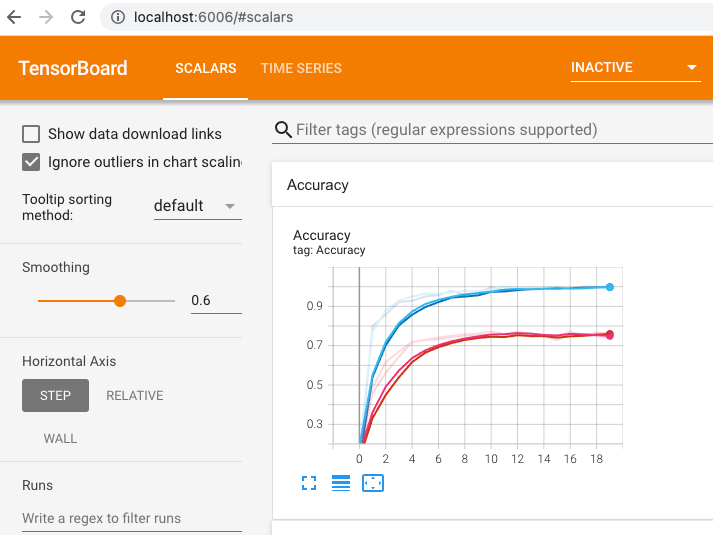

### Test the model

In [15]:
model.eval()
acc = Accuracy()
with torch.no_grad():
    pred = model(data.x.float(), data.edge_index).argmax(dim=1)
    acc.update(pred[data.test_mask], data.y[data.test_mask])
print("Accuracy: {:.4f}".format(acc.value))

Accuracy: 0.7720


## Train on Neighborhood Subgraphs <a name="train_subgraph"></a>
Alternatively, we train the model on the neighborhood subgraphs. Each subgraph contains the 2 hop neighborhood of certain seed vertices. This method  will allow us to train the model on graphs that are way larger than the CORA dataset because we don't load the whole graph into memory all at once. 

We will use the same parameters as before, but we will use the NeighborLoader to load subgraphs. Once we finish iterating over all the subgraphs generated by the loader, it is guaranteed to cover all vertices in the graph (except for those filtered by a user provided mask). 

In [16]:
# Hyperparameters
hp = {
    "batch_size": 64,
    "num_neighbors": 10,
    "num_hops": 2,
    "num_heads": 8,
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.6,
    "lr": 0.01,
    "l2_penalty": 5e-4,
}

### Construct neighborhood subgraph loader

Here we construct 3 subgraph loaders. The `train_loader` only uses vertices in the training set as seeds, the `valid_loader` only uses vertices in the validation set, and the `test_loader` only uses vertices in the test set.

In [17]:
train_loader = conn.gds.neighborLoader(
    v_in_feats=["x"],
    v_out_labels=["y"],
    v_extra_feats=["train_mask","val_mask","test_mask"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by="train_mask",
)

In [18]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats=["x"],
    v_out_labels=["y"],
    v_extra_feats=["train_mask","val_mask","test_mask"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
    filter_by="val_mask",
)

### Construct model and optimizer

We build a GAT model with 2 convolutional layers, and use the Adam optimizer with a learning rate of 0.01.

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GAT

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    in_channels=1433,
    hidden_channels=hp["hidden_dim"],
    num_layers=hp["num_layers"],
    out_channels=7,
    dropout=hp["dropout"],
    heads=hp["num_heads"]
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

### Train the model

In [21]:
from datetime import datetime

from pyTigerGraph.gds.metrics import Accumulator, Accuracy
from torch.utils.tensorboard import SummaryWriter

In [22]:
log_dir = "logs/cora/gat/subgraph/" + datetime.now().strftime("%Y%m%d-%H%M%S")
train_log = SummaryWriter(log_dir+"/train")
valid_log = SummaryWriter(log_dir+"/valid")
global_steps = 0
logs = {}
for epoch in range(10):
    # Train
    model.train()
    epoch_train_loss = Accumulator()
    epoch_train_acc = Accuracy()
    for bid, batch in enumerate(train_loader):
        batchsize = batch.x.shape[0]
        batch.to(device)
        # Forward pass
        out = model(batch.x.float(), batch.edge_index)
        # Calculate loss
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out.argmax(dim=1)
            epoch_train_acc.update(pred[batch.train_mask], batch.y[batch.train_mask])
        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["acc"] = epoch_train_acc.value
        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, Accuracy {:.4f}".format(
                epoch, bid, logs["loss"], logs["acc"]
            )
        )
        train_log.add_scalar("Loss", logs["loss"], global_steps)
        train_log.add_scalar("Accuracy", logs["acc"], global_steps)
        train_log.flush()
        global_steps += 1
    # Evaluate
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_acc = Accuracy()
    for batch in valid_loader:
        batchsize = batch.x.shape[0]
        batch.to(device)
        with torch.no_grad():
            # Forward pass
            out = model(batch.x.float(), batch.edge_index)
            # Calculate loss
            valid_loss = F.cross_entropy(out[batch.val_mask], batch.y[batch.val_mask])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out.argmax(dim=1)
            epoch_val_acc.update(pred[batch.val_mask], batch.y[batch.val_mask])
    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_acc"] = epoch_val_acc.value
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid Accuracy {:.4f}".format(
            epoch, logs["val_loss"], logs["val_acc"]
        )
    )
    valid_log.add_scalar("Loss", logs["val_loss"], global_steps)
    valid_log.add_scalar("Accuracy", logs["val_acc"], global_steps)
    valid_log.flush()

Epoch 0, Train Batch 0, Loss 1.9914, Accuracy 0.1270
Epoch 0, Train Batch 1, Loss 1.9245, Accuracy 0.1831
Epoch 0, Train Batch 2, Loss 1.8629, Accuracy 0.2394
Epoch 0, Valid Loss 1.8303, Valid Accuracy 0.3588
Epoch 1, Train Batch 0, Loss 1.6978, Accuracy 0.3099
Epoch 1, Train Batch 1, Loss 1.6699, Accuracy 0.3958
Epoch 1, Train Batch 2, Loss 1.6784, Accuracy 0.4175
Epoch 1, Valid Loss 1.6953, Valid Accuracy 0.4571
Epoch 2, Train Batch 0, Loss 1.5641, Accuracy 0.4833
Epoch 2, Train Batch 1, Loss 1.4896, Accuracy 0.5238
Epoch 2, Train Batch 2, Loss 1.4423, Accuracy 0.5742
Epoch 2, Valid Loss 1.5168, Valid Accuracy 0.6326
Epoch 3, Train Batch 0, Loss 1.3696, Accuracy 0.5417
Epoch 3, Train Batch 1, Loss 1.3325, Accuracy 0.5441
Epoch 3, Train Batch 2, Loss 1.2823, Accuracy 0.6087
Epoch 3, Valid Loss 1.3378, Valid Accuracy 0.6976
Epoch 4, Train Batch 0, Loss 1.1413, Accuracy 0.6800
Epoch 4, Train Batch 1, Loss 1.1792, Accuracy 0.6395
Epoch 4, Train Batch 2, Loss 1.1304, Accuracy 0.6729
Epoch

### Visualize training status

We can use tensorboard to visualize and track training status. If you are running this notebook on ML Workbench Cloud, please go to the Tensorboards app to start a tensorboard server (see [doc](https://docs.tigergraph.com/ml-workbench/current/on-cloud/tensorboard) for details), and you can skip the rest of this section.

Otherwise, uncomment and run the code below to start a tensorboard server locally in the background. If there is already a tensorboard server running, skip the cell below or you will get an error complaining that the port is in use. 

In [23]:
# import os
# os.system("tensorboard --logdir logs --port 6006 --bind_all &")

Once the tensorboard service is running, go to `localhost:6006` in your browser and you should see all the pretty plots as below. For details on using tensorboard, please refer to its [official doc](https://www.tensorflow.org/tensorboard/get_started).

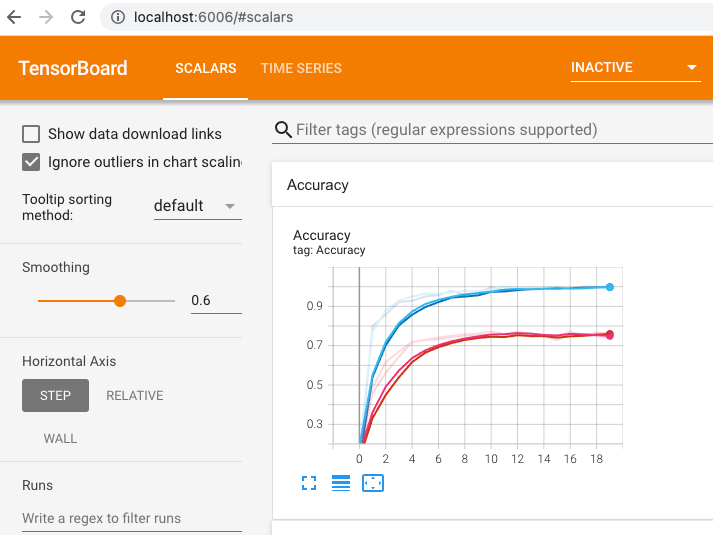

### Test the model

In [24]:
test_loader = conn.gds.neighborLoader(
    v_in_feats=["x"],
    v_out_labels=["y"],
    v_extra_feats=["train_mask","val_mask","test_mask"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
    filter_by="test_mask",
)

In [25]:
model.eval()
acc = Accuracy()
for batch in test_loader:
    batch.to(device)
    with torch.no_grad():
        pred = model(batch.x.float(), batch.edge_index).argmax(dim=1)
        acc.update(pred[batch.test_mask], batch.y[batch.test_mask])
print("Accuracy: {:.4f}".format(acc.value))

Accuracy: 0.7584


## Inference <a name="inference"></a>

Finally, we use the trained model for node classification. At this stage, we typically do inference/prediction for specific nodes instead of random batches, so we will create a new data loader.  

In [26]:
infer_loader = conn.gds.neighborLoader(
    v_in_feats=["x"],
    v_out_labels=["y"],
    v_extra_feats=["train_mask","val_mask","test_mask"],
    output_format="PyG",
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
)

In [27]:
# Fetch specific nodes by their IDs and do prediction. 
# Each node is represented by a dict with two mandatory keys: primary_id and type.
input_nodes = [{"primary_id": 7, "type": "Paper"}, 
               {"primary_id": 999, "type": "Paper"}]
data = infer_loader.fetch(input_nodes)

In [28]:
# The returned data are the neighborhood subgraphs of the input nodes.
# The original IDs of the nodes in the subgraphs are stored in the 
# `primary_id` attribute.
data

Data(edge_index=[2, 16], x=[15, 1433], y=[15], train_mask=[15], val_mask=[15], test_mask=[15], is_seed=[15], primary_id=[15])

In [29]:
# Predict. Predictions for both the input nodes and others in their 
# neighborhoods are generated.
model.eval()
pred = model(data.x.float(), data.edge_index).argmax(dim=1)
print("ID: Label")
for i,j in zip(data.primary_id, pred):
    print("{}:{}".format(i, j.item()))

ID: Label
7:3
999:2
1358:2
208:3
346:2
1761:2
1731:2
1726:2
1123:2
174:2
364:2
341:2
1765:2
1719:2
1734:2
